# Fine-tuning for Video Classification with 🤗 Transformers

This notebook shows how to fine-tune a pre-trained Vision model for Video Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder and fine-tune the model altogether on a labeled dataset.


## Dataset

This notebook uses a subset of the [UCF-101 dataset](https://www.crcv.ucf.edu/data/UCF101.php). We'll be using a subset of the dataset to keep the runtime of the tutorial short. The subset was prepared using [this notebook](https://drive.google.com/file/d/1tTScjnyiKrBz84jKe1H_hPGGXffAZuxX/view?usp=sharing) following [this guide](https://www.tensorflow.org/tutorials/load_data/video).

## Model

We'll fine-tune the [VideoMAE model](https://huggingface.co/docs/transformers/model_doc/videomae), which was pre-trained on the [Kinetics 400 dataset](https://www.deepmind.com/open-source/kinetics). You can find the other variants of VideoMAE available on 🤗 Hub [here](https://huggingface.co/models?search=videomae). You can also extend this notebook to use other video models such as [X-CLIP](https://huggingface.co/docs/transformers/model_doc/xclip#transformers.XCLIPVisionModel).

**Note** that for models where there's no classification head already available you'll have to manually attach it (randomly initialized). But this is not the case for VideoMAE since we already have a [`VideoMAEForVideoClassification`](https://huggingface.co/docs/transformers/model_doc/xclip#transformers.XCLIPVisionModel) class.

## Data preprocessing

This notebook leverages [TorchVision's](https://pytorch.org/vision/stable/transforms.html) and [PyTorchVideo's](https://pytorchvideo.org/) transforms for applying data preprocessing transformations including data augmentation.

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In [1]:
import gdown

url = 'https://drive.google.com/file/d/1c51MqwIWD4noIBlCzP4DHZV9RkguGSsu/view?usp=sharing'
output_path = 'UCF101TrainTestSplits-Kaggle.zip'
gdown.download(url, output_path, quiet=False,fuzzy=True)

import gdown

url = 'https://drive.google.com/file/d/1NbqH3E-qI9nYxYtMRnEshnKKjjqvuesS/view?usp=sharing'
output_path = 'ucf101.zip'
gdown.download(url, output_path, quiet=False,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1c51MqwIWD4noIBlCzP4DHZV9RkguGSsu
To: /content/UCF101TrainTestSplits-Kaggle.zip
100%|██████████| 119k/119k [00:00<00:00, 92.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1NbqH3E-qI9nYxYtMRnEshnKKjjqvuesS
From (redirected): https://drive.google.com/uc?id=1NbqH3E-qI9nYxYtMRnEshnKKjjqvuesS&confirm=t&uuid=c5f66a91-1e7a-4568-86e8-4f3b9d2e0396
To: /content/ucf101.zip
100%|██████████| 3.80G/3.80G [00:25<00:00, 152MB/s]


'ucf101.zip'

In [2]:
!unzip /content/UCF101TrainTestSplits-Kaggle.zip
!unzip /content/ucf101.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c02.avi  
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c03.avi  
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c04.avi  
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c05.avi  
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c06.avi  
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c07.avi  
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi  
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi  
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi  
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi  
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi  
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g09_c01.avi  
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g09_c02.avi  
  inflating: train/ApplyEyeMakeup/v_ApplyEyeMakeup_g09_c03.avi  
  inflating: train/ApplyEyeMakeup/v_App

In [1]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 51 # batch size for training and evaluation

Before we start, let's install the `pytorchvideo`, `transformers`, and `evaluate` libraries.

In [2]:
!pip install pytorchvideo transformers==4.30 evaluate -q

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Then you need to install Git-LFS to upload your model checkpoints:

In [4]:
!git config --global credential.helper store

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [5]:
from transformers.utils import send_example_telemetry

send_example_telemetry("video_classification_notebook", framework="pytorch")

## Fine-tuning a model on a video classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on a Video Classification dataset.

Given a video, the goal is to predict an appropriate class for it, like "archery".

### Loading the dataset

Let's now count the number of total videos we have.

In [6]:
import pathlib
dataset_root_path = pathlib.Path('/content/')

In [7]:
video_count_train = len(list(dataset_root_path.glob('train/*/*.avi')))
video_count_test_seen = len(list(dataset_root_path.glob('test_seen/*/*.avi')))
video_count_test_unseen = len(list(dataset_root_path.glob('test_unseen/*/*.avi')))

In [8]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    +
    list(dataset_root_path.glob("test_seen/*/*.avi"))
    +
    list(dataset_root_path.glob("test_unseen/*/*.avi"))
)
all_video_file_paths[:5]
print(len(all_video_file_paths))

6816


Next up, we derive the set of labels we have in the dataset. Let's also create two dictionaries that'll be helpful when initializing the model:

* `label2id`: maps the class names to integers.
* `id2label`: maps the integers to class names.

In [9]:
class_labels = sorted({str(path).split("/")[-2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"{len(class_labels)} Unique classes: {list(label2id.keys())}.")

51 Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BasketballDunk', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BrushingTeeth', 'CliffDiving', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 'FieldHockeyPenalty', 'FloorGymnastics', 'FrisbeeCatch', 'FrontCrawl', 'Haircut', 'HammerThrow', 'Hammering', 'HandStandPushups', 'HandstandWalking', 'HeadMassage', 'IceDancing', 'Knitting', 'LongJump', 'MoppingFloor', 'ParallelBars', 'PlayingCello', 'PlayingDaf', 'PlayingDhol', 'PlayingFlute', 'PlayingSitar', 'Rafting', 'ShavingBeard', 'Shotput', 'SkyDiving', 'SoccerPenalty', 'StillRings', 'SumoWrestling', 'Surfing', 'TableTennisShot', 'Typing', 'UnevenBars', 'WallPushups', 'WritingOnBoard'].


### Loading the model

In the next cell, we initialize a video classification model where the encoder is initialized with the pre-trained parameters and the classification head is randomly initialized. We also initialize the feature extractor associated to the model. This will come in handy during writing the preprocessing pipeline for our dataset.

In [10]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification


image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at MCG-NJU/videomae-base were not used when initializing VideoMAEForVideoClassification: ['decoder.decoder_layers.3.layernorm_before.bias', 'decoder.decoder_layers.2.attention.attention.key.weight', 'decoder.decoder_layers.0.output.dense.bias', 'decoder.decoder_layers.0.attention.output.dense.bias', 'decoder.decoder_layers.0.attention.attention.key.weight', 'decoder.decoder_layers.3.attention.attention.q_bias', 'decoder.decoder_layers.2.att

The warning is telling us we are throwing away some weights (e.g. the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

**Note** that [this checkpoint](https://huggingface.co/MCG-NJU/videomae-base-finetuned-kinetics) leads to better performance on this task as the checkpoint was obtained fine-tuning on a similar downstream task having considerable domain overlap. You can check out [this checkpoint](https://huggingface.co/sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset) which was obtained by fine-tuning `MCG-NJU/videomae-base-finetuned-kinetics` and it obtains much better performance.  

### Constructing the datasets for training

For preprocessing the videos, we'll leverage the [PyTorch Video library](https://pytorchvideo.org/). We start by importing the dependencies we need.

In [11]:
import pytorchvideo.data

# in /usr/local/lib/python3.10/dist-packages/pytorchvideo/transforms/augmentations.py
# change torchvision.transforms.functional_tensor
#  to import torchvision.transforms.functional as F_t
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

For the training dataset transformations, we use a combination of uniform temporal subsampling, pixel normalization, random cropping, and random horizontal flipping. For the validation and evaluation dataset transformations, we keep the transformation chain the same except for random cropping and horizontal flipping. To learn more about the details of these transformations check out the [official documentation of PyTorch Video](https://pytorchvideo.org).  

We'll use the `image_processor` associated with the pre-trained model to obtain the following information:

* Image mean and standard deviation with which the video frame pixels will be normalized.
* Spatial resolution to which the video frames will be resized.

In [12]:
from pytorchvideo.data.labeled_video_paths import LabeledVideoPaths
from pytorchvideo.data.clip_sampling import ClipSampler
import torch
from typing import Any, Callable, Dict, List, Optional, Tuple, Type

class ZS_LabeledVideoDataset(pytorchvideo.data.LabeledVideoDataset):
    def __init__(
        self,
        labeled_video_paths: List[Tuple[str, Optional[dict]]],
        clip_sampler: ClipSampler,
        map_label2id: Dict[str, int],
        video_sampler: Type[torch.utils.data.Sampler] = torch.utils.data.RandomSampler,
        transform: Optional[Callable[[dict], Any]] = None,
        decode_audio: bool = True,
        decoder: str = "pyav",
    ) -> None:
        super().__init__(
            labeled_video_paths,
            clip_sampler,
            video_sampler,
            transform,
            decode_audio,
            decoder,
        )
        self.map_label2id = map_label2id


    def __next__(self) -> dict:
        """
        Retrieves the next clip based on the clip sampling strategy and video sampler.

        Returns:
            A dictionary with the following format.

            .. code-block:: text

                {
                    'video': <video_tensor>, eg.torch.Size([3, 16, 224, 224]),
                    'video_name': <file_name_str>, eg. v_FrontCrawl_g04_c06.avi,
                    'label': <index_label>, eg. 21,
                    'video_index': <video_index>, eg. 2054,
                    'clip_index': <clip_index>, eg. 0,
                    'aug_index': <aug_index>, eg. 0
                    **({"audio": audio_samples} if audio_samples is not None else {}), eg. torch.Size([93312])
                }
        """
        sample_dict = super().__next__()

        # Map the label to its corresponding ID of all seen and unseen classes
        class_name = sample_dict['video_name'].split('_')[1]

        sample_dict['label'] = self.map_label2id[class_name]

        return sample_dict


def ZS_labeled_video_dataset(
    data_path: str,
    clip_sampler: ClipSampler,
    map_label2id: Dict[str, int],
    video_sampler: Type[torch.utils.data.Sampler] = torch.utils.data.RandomSampler,
    transform: Optional[Callable[[Dict[str, Any]], Dict[str, Any]]] = None,
    video_path_prefix: str = "",
    decode_audio: bool = True,
    decoder: str = "pyav",
) -> ZS_LabeledVideoDataset:
    """
    A helper function to create ``LabeledVideoDataset`` object for Ucf101 and Kinetics datasets.
    adapted from https://pytorchvideo.readthedocs.io/en/latest/_modules/pytorchvideo/data/labeled_video_dataset.html
    """
    labeled_video_paths = LabeledVideoPaths.from_path(data_path)
    labeled_video_paths.path_prefix = video_path_prefix
    dataset = ZS_LabeledVideoDataset(
        labeled_video_paths,
        clip_sampler,
        map_label2id,
        video_sampler,
        transform,
        decode_audio=decode_audio,
        decoder=decoder,
    )
    return dataset

def Ucf101(
    data_path: str,
    clip_sampler: ClipSampler,
    map_label2id: Dict[str, int],
    video_sampler: Type[torch.utils.data.Sampler] = torch.utils.data.RandomSampler,
    transform: Optional[Callable[[Dict[str, Any]], Dict[str, Any]]] = None,
    video_path_prefix: str = "",
    decode_audio: bool = True,
    decoder: str = "pyav",
) -> ZS_LabeledVideoDataset:
    """
    A helper function to create ``LabeledVideoDataset`` object for the Ucf101 dataset.
    adapted from https://pytorchvideo.readthedocs.io/en/latest/_modules/pytorchvideo/data/ucf101.html
    """

    torch._C._log_api_usage_once("PYTORCHVIDEO.dataset.Ucf101")

    return ZS_labeled_video_dataset(
        data_path,
        clip_sampler,
        map_label2id,
        video_sampler,
        transform,
        video_path_prefix,
        decode_audio,
        decoder,
    )


In [13]:
num_frames_to_sample = model.config.num_frames
sample_rate = 8
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

In [14]:
print('num_frames_to_sample', num_frames_to_sample)
print('clip_duration', clip_duration)

num_frames_to_sample 16
clip_duration 4.266666666666667


Custom Video Sampler

In [15]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 8
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    map_label2id=label2id,
    decode_audio=True,
    transform=train_transform,
)

# Test seen and unseen datasets' transformations.
test_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Test seen and unseen datasets.
test_seen_dataset = Ucf101(
    data_path=os.path.join(dataset_root_path, "test_seen"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    map_label2id=label2id,
    decode_audio=True,
    transform=test_transform,
)

test_unseen_dataset = Ucf101(
    data_path=os.path.join(dataset_root_path, "test_unseen"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    map_label2id=label2id,
    decode_audio=True,
    transform=test_transform,
)

**Note**: The above dataset pipelines are taken from the [official PyTorch Video example](https://pytorchvideo.org/docs/tutorial_classification#dataset). We're using the [`pytorchvideo.data.Ucf101()`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.Ucf101) function because it's tailored for the UCF-101 dataset. Under the hood, it returns a [`pytorchvideo.data.labeled_video_dataset.LabeledVideoDataset`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.LabeledVideoDataset) object. `LabeledVideoDataset` class is the base class for all things video in the PyTorch Video dataset. So, if you wanted to use a custom dataset not supported off-the-shelf by PyTorch Video, you can extend the `LabeledVideoDataset` class accordingly. Refer to the `data` API [documentation to](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html) learn more. Also, if your dataset follows a similar structure (as shown above), then using the `pytorchvideo.data.Ucf101()` should work just fine.

In [16]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
# train_dataset.num_videos,
test_seen_dataset.num_videos
# , test_unseen_dataset.num_videos

555

Let's now take a preprocessed video from the dataset and investigate it.

In [17]:
sample_video = next(iter(test_seen_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label', 'audio'])

In [18]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video" or k == "audio":
            print(k, sample_video[k].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video['label']]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name v_LongJump_g23_c04.avi
video_index 360
clip_index 0
aug_index 0
label 30
audio torch.Size([188928])
Video label: LongJump


We can also visualize the preprocessed videos for easier debugging.

In [19]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

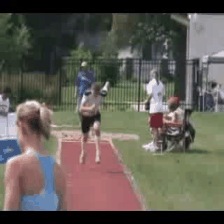

In [25]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

### Training the model

We'll leverage [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) from  🤗 Transformers for training the model. To instantiate a `Trainer`, we will need to define the training configuration and an evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to configure the training. It requires an output folder name, which will be used to save the checkpoints of the model. It also helps sync all the information in the model repository on 🤗 Hub.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('video' in particular) in order to create `pixel_values` (which is a mandatory key our model expects in its inputs).

In [20]:
! pip install accelerate -U

In [21]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101"
num_epochs = 4

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
    # tf32=True,
    dataloader_num_workers = 8,
    # dataloader_persistent_workers = True

)

There's no need to define `max_steps` when instantiating `TrainingArguments`. Since the dataset returned by `pytorchvideo.data.Ucf101()` doesn't implement the `__len__()` method we had to specify `max_steps`.  

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we'll load now. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [22]:
import evaluate

metric = evaluate.load("accuracy")

In [23]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

**A note on evaluation**:

In the [VideoMAE paper](https://arxiv.org/abs/2203.12602), the authors use the following evaluation strategy. They evaluate the model on several clips from test videos and apply different crops to those clips and report the aggregate score. However, in the interest of simplicity and brevity, we don't consider that in this tutorial.

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [24]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    print("pixel_values", pixel_values.shape, 'labels', labels.shape)
    print(labels)
    return {"pixel_values": pixel_values, "labels": labels}

Define a custom batch sampler so that every batch only contains samples of different labels

In [50]:
# import torch
# from torch.utils.data import Dataset, DataLoader, Sampler
# import numpy as np
# import random

# class BalancedBatchSampler(Sampler):
#     def __init__(self, labels):
#         random.seed(0)

#         self.labels = np.array(labels)
#         self.unique_labels = np.unique(self.labels)
#         print("unique_labels", self.unique_labels)
#         self.label_to_indices = {label: np.where(self.labels == label)[0] for label in self.unique_labels}

#     def __iter__(self):
#         batch = []
#         for label in self.unique_labels:
#             indices = self.label_to_indices[label]
#             chosen_index = np.random.choice(indices)
#             batch.append(chosen_index)
#         np.random.shuffle(batch)
#         yield batch

#     def __len__(self):
#         return len(self.unique_labels)  # This is one batch per epoch. Adjust as needed.


Override the HuggingFace Trainer with custom batch sampler

In [51]:
# from transformers import Trainer

# class CustomTrainer(Trainer):
#     def get_train_dataloader(self) -> DataLoader:
#         if self.train_dataset is None:
#             raise ValueError("Trainer: training requires a train_dataset.")
#         train_sampler = BalancedBatchSampler(class_labels)
#         return DataLoader(
#             self.train_dataset,
#             batch_size=self.args.train_batch_size,
#             sampler=train_sampler,
#             collate_fn=self.data_collator,
#             drop_last=self.args.dataloader_drop_last,
#             num_workers=self.args.dataloader_num_workers,
#         )

# # class CustomTrainer(Trainer):
# #     def _get_train_sampler(self):
# #       return BalancedBatchSampler(self.train_dataset.labels)

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [25]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_seen_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/feliciaaaluo/videomae-base-finetuned-ucf101 into local empty directory.


Download file pytorch_model.bin:   0%|          | 26.2k/329M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 4.62k/4.62k [00:00<?, ?B/s]

Download file runs/Mar30_20-07-32_798af3928b3d/events.out.tfevents.1711829270.798af3928b3d.6123.0: 100%|######…

Download file runs/Mar29_18-44-51_42455a9b85fc/events.out.tfevents.1711737909.42455a9b85fc.7182.0:   9%|9     …

Download file model.safetensors:   0%|          | 24.0k/329M [00:00<?, ?B/s]

Download file runs/Mar30_20-09-14_798af3928b3d/events.out.tfevents.1711829364.798af3928b3d.7783.0:  27%|##7   …

Clean file training_args.bin:  22%|##1       | 1.00k/4.62k [00:00<?, ?B/s]

Download file runs/Mar29_18-44-51_42455a9b85fc/events.out.tfevents.1711740866.42455a9b85fc.7182.1: 100%|######…

Clean file runs/Mar30_20-07-32_798af3928b3d/events.out.tfevents.1711829270.798af3928b3d.6123.0:  15%|#4       …

Download file runs/Mar29_18-40-33_42455a9b85fc/events.out.tfevents.1711737743.42455a9b85fc.5516.0: 100%|######…

Clean file runs/Mar29_18-44-51_42455a9b85fc/events.out.tfevents.1711737909.42455a9b85fc.7182.0:   1%|1        …

Clean file runs/Mar29_18-44-51_42455a9b85fc/events.out.tfevents.1711740866.42455a9b85fc.7182.1: 100%|#########…

Clean file runs/Mar30_20-09-14_798af3928b3d/events.out.tfevents.1711829364.798af3928b3d.7783.0:   1%|1        …

Clean file runs/Mar29_18-40-33_42455a9b85fc/events.out.tfevents.1711737743.42455a9b85fc.5516.0:  24%|##4      …

Clean file pytorch_model.bin:   0%|          | 1.00k/329M [00:00<?, ?B/s]

Clean file model.safetensors:   0%|          | 1.00k/329M [00:00<?, ?B/s]

You might wonder why we pass along the `image_processor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [26]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


pixel_values torch.Size([51, 16, 3, 224, 224]) pixel_values labelstorch.Size([51, 16, 3, 224, 224]) torch.Size([51]) 
labelstensor([35, 43, 27, 46, 24, 31, 27,  6, 19, 18, 32, 43, 35, 44, 45, 27, 43, 18,
        14, 42, 23, 32, 29, 40, 35, 38, 11, 35, 44, 42, 21, 34, 29, 15, 18,  6,
        30, 45, 14, 49, 23, 25,  2, 38, 35, 31, 15, 16,  6, 19,  2])
 torch.Size([51])
tensor([19,  1, 14, 45, 22, 46, 33, 23, 20, 34, 15, 40, 31, 26,  8, 23,  3, 21,
        11, 42, 32,  3, 34, 41, 48, 34, 49, 30, 32, 42,  2, 38, 21,  2, 41, 22,
        10, 40, 20,  9,  0, 35,  9, 49,  3,  8, 42, 26, 16, 21,  8])
pixel_values torch.Size([51, 16, 3, 224, 224]) labels torch.Size([51])
tensor([21, 49, 10,  1, 20, 18, 18,  6, 48, 31,  6, 38, 11, 44, 32, 28,  1, 23,
        11, 45, 14, 14, 10, 48,  9, 10, 42, 15, 24, 12, 34, 24, 15, 10, 16, 28,
        27, 26, 45,  9, 45, 38,  6, 23, 19, 24, 31, 43, 45, 31, 20])
pixel_values torch.Size([51, 16, 3, 224, 224]) labels pixel_valuestorch.Size([51])
 tensor([45, 22, 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78e390325360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.61 GiB. GPU 0 has a total capacity of 14.75 GiB of which 263.06 MiB is free. Process 133973 has 14.48 GiB memory in use. Of the allocated memory 11.66 GiB is allocated by PyTorch, and 2.69 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
trainer.evaluate(test_seen_dataset)

{'eval_loss': 3.965297222137451,
 'eval_accuracy': 0.011843079200592153,
 'eval_runtime': 100.2948,
 'eval_samples_per_second': 13.47,
 'eval_steps_per_second': 2.253}

In [ ]:
trainer.save_model()
test_unseen_results = trainer.evaluate(test_unseen_dataset)
trainer.log_metrics("test_unseen", test_unseen_results)
trainer.save_metrics("test_unseen", test_unseen_results)
test_seen_results = trainer.evaluate(test_seen_dataset)
trainer.log_metrics("test_seen", test_seen_results)
trainer.save_metrics("test_seen", test_seen_results)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/329M [00:00<?, ?B/s]

Upload file runs/Mar29_18-44-51_42455a9b85fc/events.out.tfevents.1711737909.42455a9b85fc.7182.0:   0%|        …

To https://huggingface.co/feliciaaaluo/videomae-base-finetuned-ucf101
   67b7b5b..c6e21ef  main -> main

   67b7b5b..c6e21ef  main -> main

To https://huggingface.co/feliciaaaluo/videomae-base-finetuned-ucf101
   c6e21ef..e6e8fb8  main -> main

   c6e21ef..e6e8fb8  main -> main

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


***** test_unseen metrics *****
  epoch                   =       3.25
  eval_accuracy           =        0.0
  eval_loss               =     8.6467
  eval_runtime            = 0:03:28.94
  eval_samples_per_second =     23.365
  eval_steps_per_second   =      5.844


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


***** test_seen metrics *****
  epoch                   =       3.25
  eval_accuracy           =     0.9682
  eval_loss               =     0.1208
  eval_runtime            = 0:00:58.57
  eval_samples_per_second =     23.065
  eval_steps_per_second   =      5.771


You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [ ]:
trainer.push_to_hub()

Upload file runs/Mar29_18-44-51_42455a9b85fc/events.out.tfevents.1711740866.42455a9b85fc.7182.1: 100%|########…

To https://huggingface.co/feliciaaaluo/videomae-base-finetuned-ucf101
   e6e8fb8..bbc6126  main -> main

   e6e8fb8..bbc6126  main -> main

To https://huggingface.co/feliciaaaluo/videomae-base-finetuned-ucf101
   bbc6126..758be4b  main -> main

   bbc6126..758be4b  main -> main



'https://huggingface.co/feliciaaaluo/videomae-base-finetuned-ucf101/commit/bbc61269b3352a843a3b26efa5937c7c3212bfe0'

Now that our model is trained, let's use it to run inference on a video from `test_dataset`.

## Inference

Let's load the trained model checkpoint and fetch a video from `test_dataset`.

In [ ]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

NameError: name 'new_model_name' is not defined

In [ ]:
sample_test_video = next(iter(test_unseen_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name v_PlayingFlute_g09_c04.avi
video_index 585
clip_index 1
aug_index 0
label 36
audio torch.Size([94464])
Video label: PlayingFlute


We then prepare the video as a `torch.Tensor` and run inference.

In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [ ]:
logits = run_inference(trained_model, sample_test_video["video"])

We can now check if the model got the prediction right.

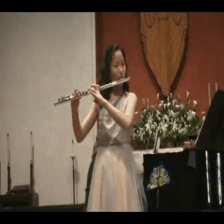

In [ ]:
display_gif(sample_test_video["video"])

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Archery


And it looks like it got it right!

You can also use this model to bring in your own videos. Check out [this Space](https://huggingface.co/spaces/sayakpaul/video-classification-ucf101-subset) to know more. The Space will also show you how to run inference for a single video file.

<br><div align=center>
    <img src="https://i.ibb.co/7nW4Rkn/sample-results.gif" width=700/>
</div>

## Next steps

Now that you've learned to train a well-performing video classification model on a custom dataset here is some homework for you:

* Increase the dataset size: include more classes and more samples per class.
* Try out different hyperparameters to study how the model converges.
* Analyze the classes for which the model fails to perform well.
* Try out a different video encoder.

Don't forget to share your models with the community =)

## Eval

In [ ]:
from tqdm import tqdm

def inference(model, dataset):

    total_preds = []
    total_labels = []
    total_losses = []
    total_confidences = []


    for dict_file in tqdm(dataset):
        video = dict_file["video"].permute(1, 0, 2, 3)
        label = dict_file['label']
        inputs = {
            "pixel_values": video.unsqueeze(0),
            "labels": torch.tensor(label)
        }
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        model = model.to(device)

        # forward pass
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            loss = outputs.loss.item()
        pred_index = logits.argmax(-1).item()
        logits = logits.flatten().softmax(dim=0)
        confidence = logits[label].item()

        total_preds.append(pred_index)
        total_losses.append(loss)
        total_labels.append(label)
        total_confidences.append(confidence)



    total_preds = np.asarray(total_preds)
    total_losses = np.asarray(total_losses)
    total_labels = np.asarray(total_labels)
    total_confidences = np.asarray(total_confidences)


    return total_preds, total_losses, total_labels, total_confidences

total_preds, total_losses, total_labels, total_confidences = inference(model, test_seen_dataset)

1352it [02:45,  8.19it/s]


### Confusion Matrix

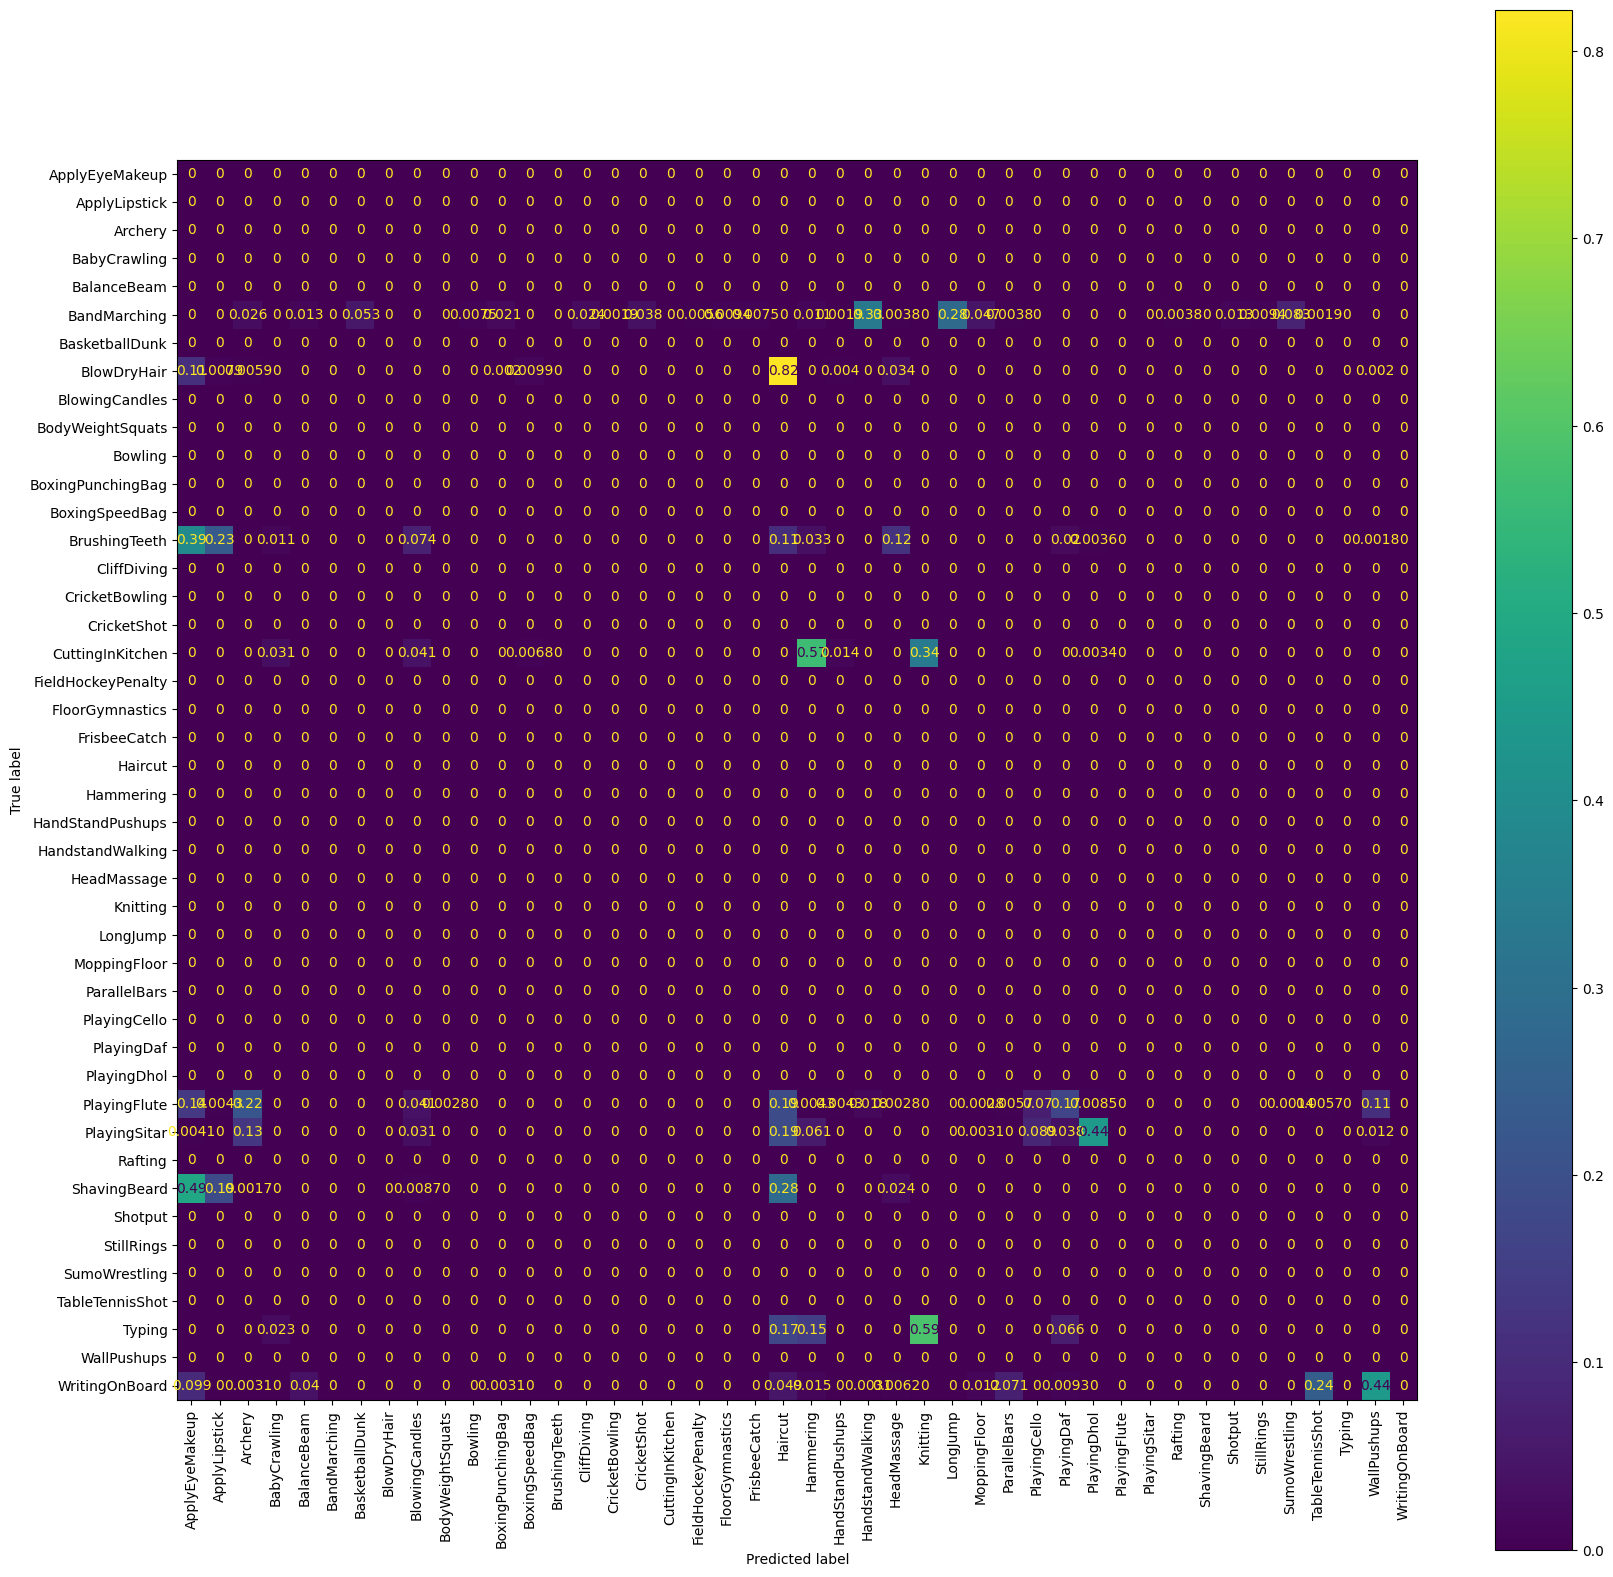

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# filtered labels that does not have data
def plot_confusion_matrix(y_true, y_pred, labels, fsize=(15, 15)):
    # Find unique labels in y_true and y_pred
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))

    # Filter labels and create a mapping from original label indices to new indices
    filtered_labels = [labels[i] for i in unique_labels]
    label_mapping = {label: i for i, label in enumerate(unique_labels)}

    # Map y_true and y_pred to new label indices
    mapped_y_true = np.vectorize(label_mapping.get)(y_true)
    mapped_y_pred = np.vectorize(label_mapping.get)(y_pred)

    # Plot confusion matrix with filtered labels
    fig, ax = plt.subplots(figsize=fsize)
    ConfusionMatrixDisplay.from_predictions(mapped_y_true, mapped_y_pred, ax=ax, labels=np.arange(len(filtered_labels)), display_labels=filtered_labels, xticks_rotation="vertical", normalize='true')
    plt.show()
    return

plot_confusion_matrix(total_labels, total_preds, class_labels, fsize=(20, 20))

### Average CE & Accuracy per Class

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


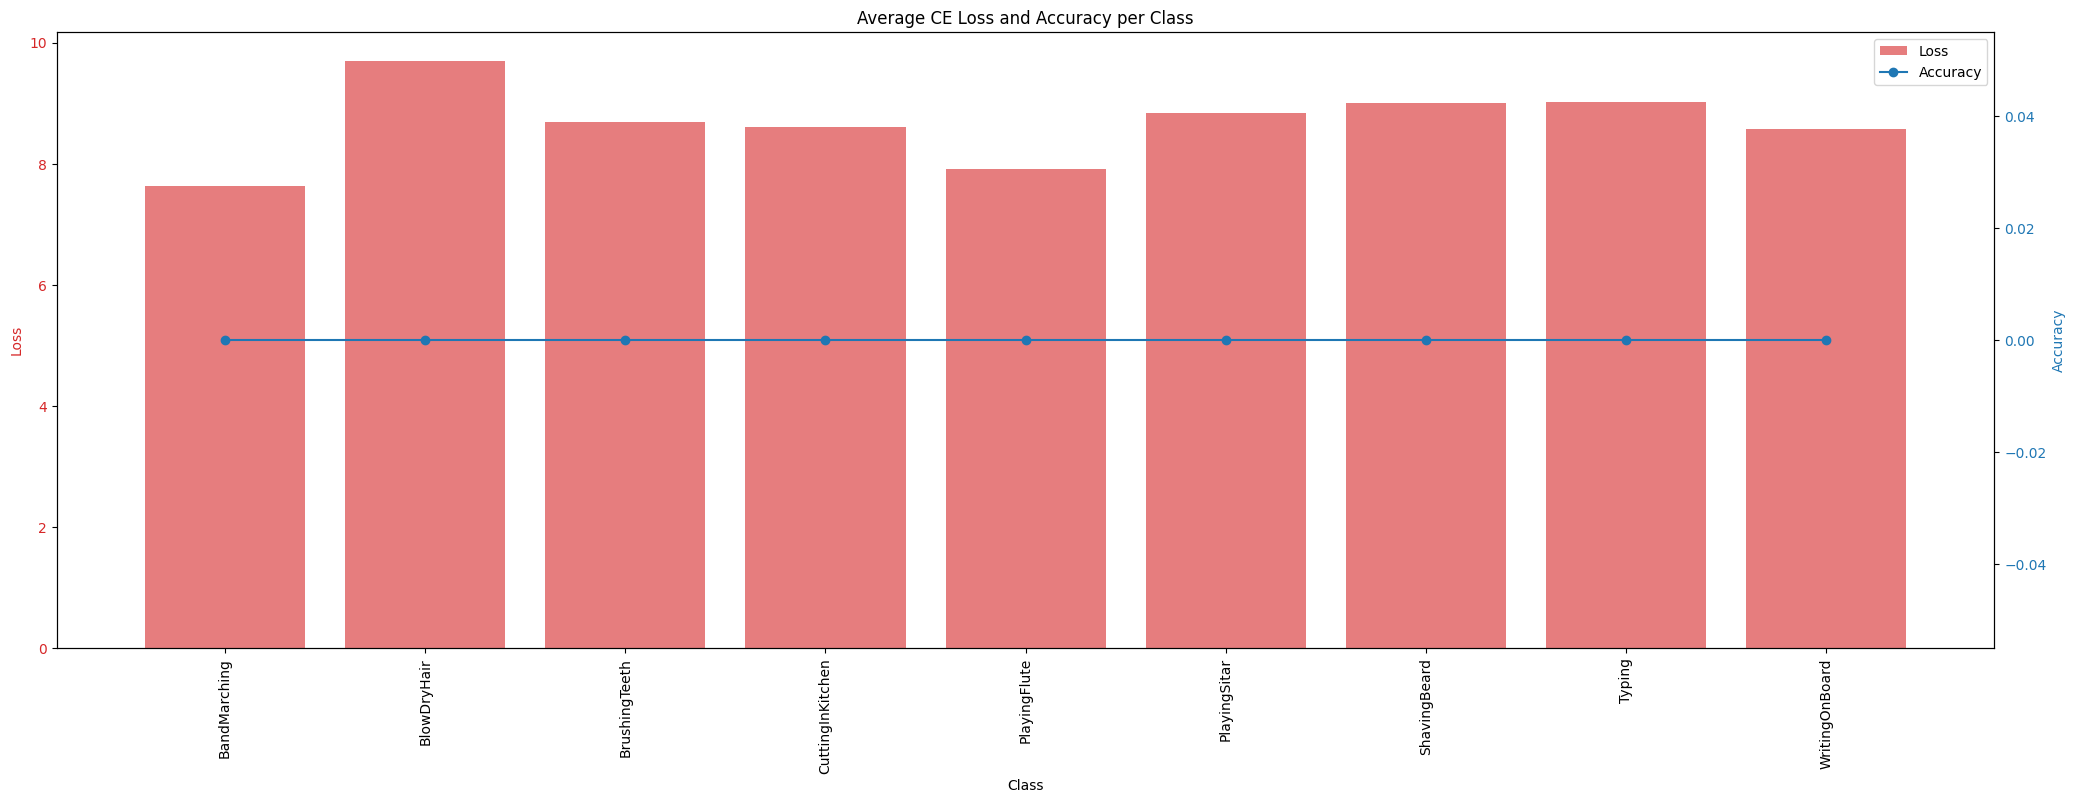

In [ ]:
import collections

def loss_acc_per_class(total_losses, total_preds, total_labels, classes):
    # loss
    loss_per_class = {class_id: [] for class_id in range(len(classes))}
    for i, label in enumerate(total_labels):
        loss_per_class[label].append(total_losses[i])
    for k, v in loss_per_class.items():
        loss_per_class[k] = np.mean(np.asarray(v))
        # print(k, v)

    # Data
    x = [classes[i] for i in loss_per_class.keys()]
    yloss = list(loss_per_class.values())

    # accuracy
    acc_per_class = {class_id: [] for class_id in range(len(classes))}
    total_preds = total_preds.flatten()

    for i, label in enumerate(total_labels):
        if label == total_preds[i]: acc = 1
        else: acc = 0
        acc_per_class[label].append(acc)

    for k, v in acc_per_class.items():
        acc_per_class[k] = np.mean(np.asarray(v))
        # print(k, v)

    # Data
    x = [classes[i] for i in acc_per_class.keys()]
    yacc = list(acc_per_class.values())

    # Create figure and first axis
    fig, ax1 = plt.subplots(figsize=(25, 8))

    # exclude class with 0 data
    x = [x[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]
    filt_yloss = [yloss[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]
    yacc =  [yacc[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]

    # Plot loss
    color = 'tab:red'
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Loss', color=color)
    ax1.bar(x, filt_yloss, color=color, alpha=0.6, label='Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)

    # Create second axis for accuracy
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(x, yacc, color=color, marker='o', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)

    # Title and legend
    plt.title('Average CE Loss and Accuracy per Class')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

    # Show plot
    plt.show()

    return


loss_acc_per_class(total_losses, total_preds, total_labels, class_labels)


### Average Confidence and Accuracy per Class

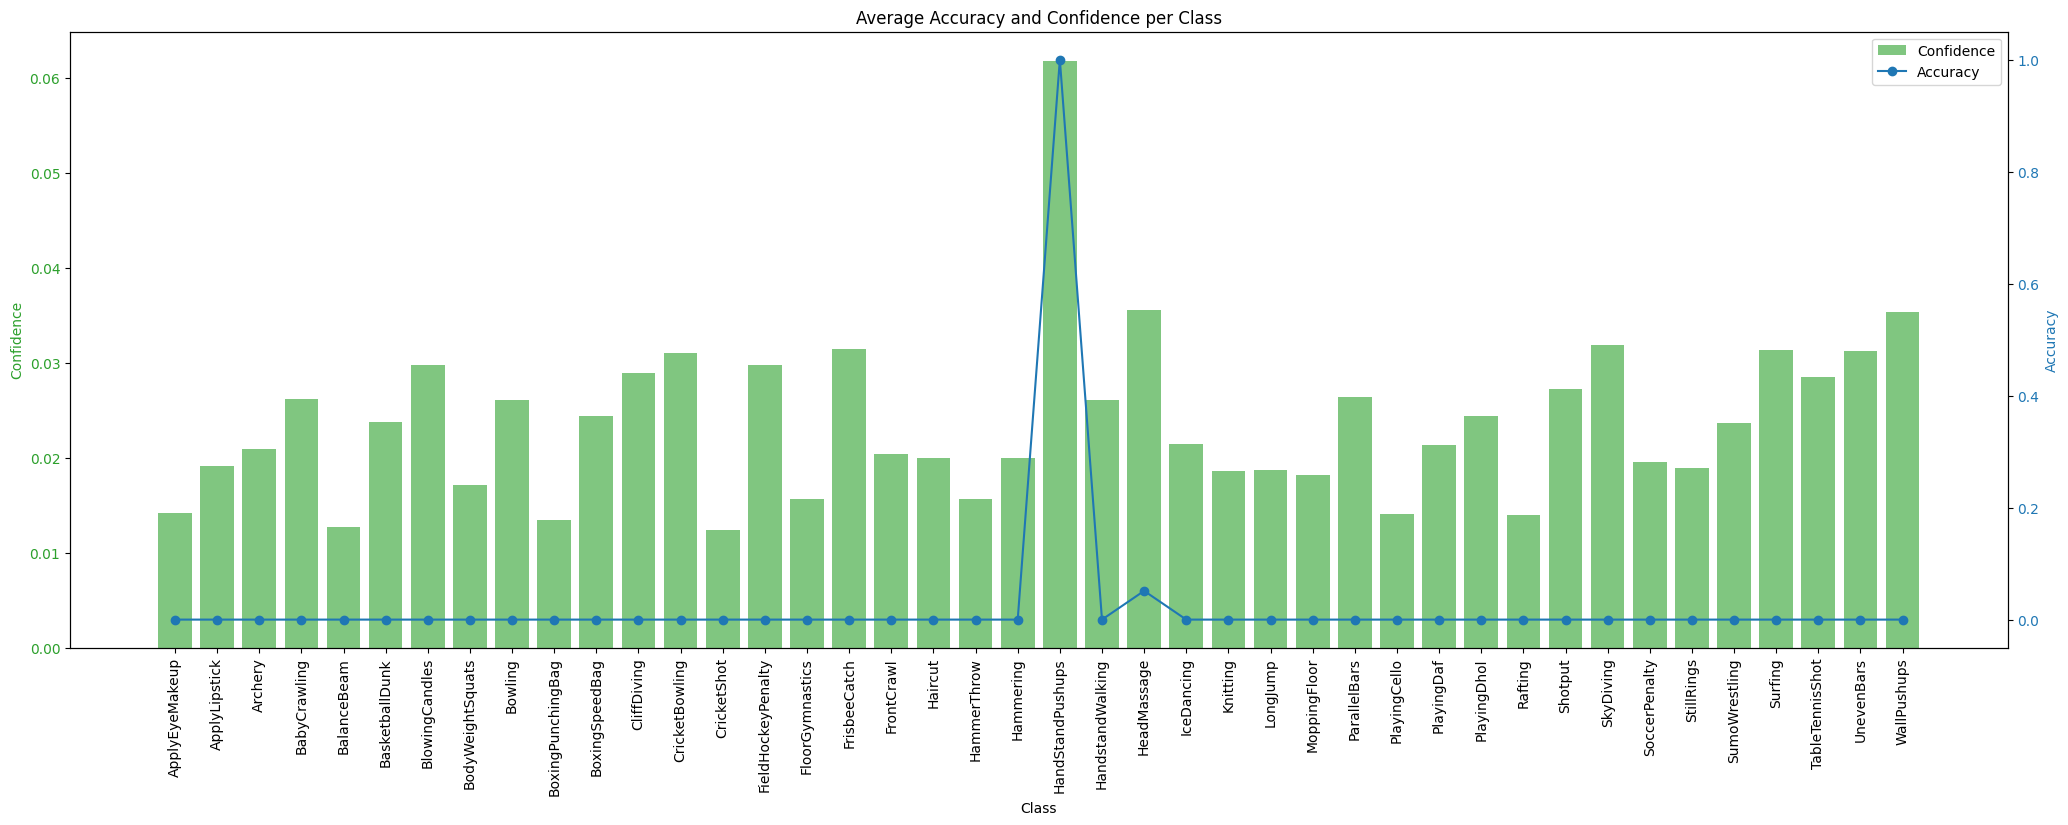

In [ ]:
import collections

def conf_acc_per_class(total_losses, total_preds, total_labels, classes):
    # loss
    loss_per_class = {class_id: [] for class_id in range(len(classes))}
    for i, label in enumerate(total_labels):
        loss_per_class[label].append(total_losses[i])
    for k, v in loss_per_class.items():
        loss_per_class[k] = np.mean(np.asarray(v))
        # print(k, v)

    # Data
    x = [classes[i] for i in loss_per_class.keys()]
    yloss = list(loss_per_class.values())

    # accuracy
    acc_per_class = {class_id: [] for class_id in range(len(classes))}
    total_preds = total_preds.flatten()

    for i, label in enumerate(total_labels):
        if label == total_preds[i]: acc = 1
        else: acc = 0
        acc_per_class[label].append(acc)

    for k, v in acc_per_class.items():
        acc_per_class[k] = np.mean(np.asarray(v))
        # print(k, v)

    # Data
    x = [classes[i] for i in acc_per_class.keys()]
    yacc = list(acc_per_class.values())

    # Create figure and first axis
    fig, ax1 = plt.subplots(figsize=(25, 8))

    # exclude class with 0 data
    x = [x[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]
    filt_yloss = [yloss[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]
    yacc =  [yacc[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]

    # Plot loss
    color = 'tab:green'
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Confidence', color=color)
    ax1.bar(x, filt_yloss, color=color, alpha=0.6, label='Confidence')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)

    # Create second axis for accuracy
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(x, yacc, color=color, marker='o', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)

    # Title and legend
    plt.title('Average Accuracy and Confidence per Class')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

    # Show plot
    plt.show()

    return


conf_acc_per_class(total_confidences, total_preds, total_labels, class_labels)


## Recon Error

In [ ]:
from transformers import VideoMAEForPreTraining
recon_model = VideoMAEForPreTraining.from_pretrained(model_ckpt, output_hidden_states=True )

Some weights of the model checkpoint at feliciaaaluo/videomae-base-finetuned-ucf101 were not used when initializing VideoMAEForPreTraining: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing VideoMAEForPreTraining from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VideoMAEForPreTraining from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of VideoMAEForPreTraining were not initialized from the model checkpoint at feliciaaaluo/videomae-base-finetuned-ucf101 and are newly initialized: ['decoder.decoder_layers.0.intermediate.dense.weight', 'decoder.decoder_layers.1.layernorm_before.bias', 'decoder.decoder_layers.0.layernorm_before.weight', 'decoder.decoder_layers

In [ ]:
from tqdm import tqdm

def recon_inference(model, dataset):

    total_losses = []
    total_labels = []

    num_patches_per_frame = (model.config.image_size // model.config.patch_size) ** 2
    seq_length = (model.config.num_frames // model.config.tubelet_size) * num_patches_per_frame
    bool_masked_pos = torch.randint(0, 2, (1, seq_length)).bool()

    for dict_file in tqdm(dataset):
        video = dict_file["video"].permute(1, 0, 2, 3)
        label = dict_file['label']

        # forward pass
        with torch.no_grad():
            outputs = model(video.unsqueeze(0), bool_masked_pos=bool_masked_pos)
            loss = outputs.loss.item()

        total_losses.append(loss)
        total_labels.append(label)

    total_losses = np.asarray(total_losses)
    total_labels = np.asarray(total_labels)

    return total_losses, total_labels

total_recon_losses, total_labels = recon_inference(recon_model, test_seen_dataset)

4882it [1:23:38,  1.03s/it]


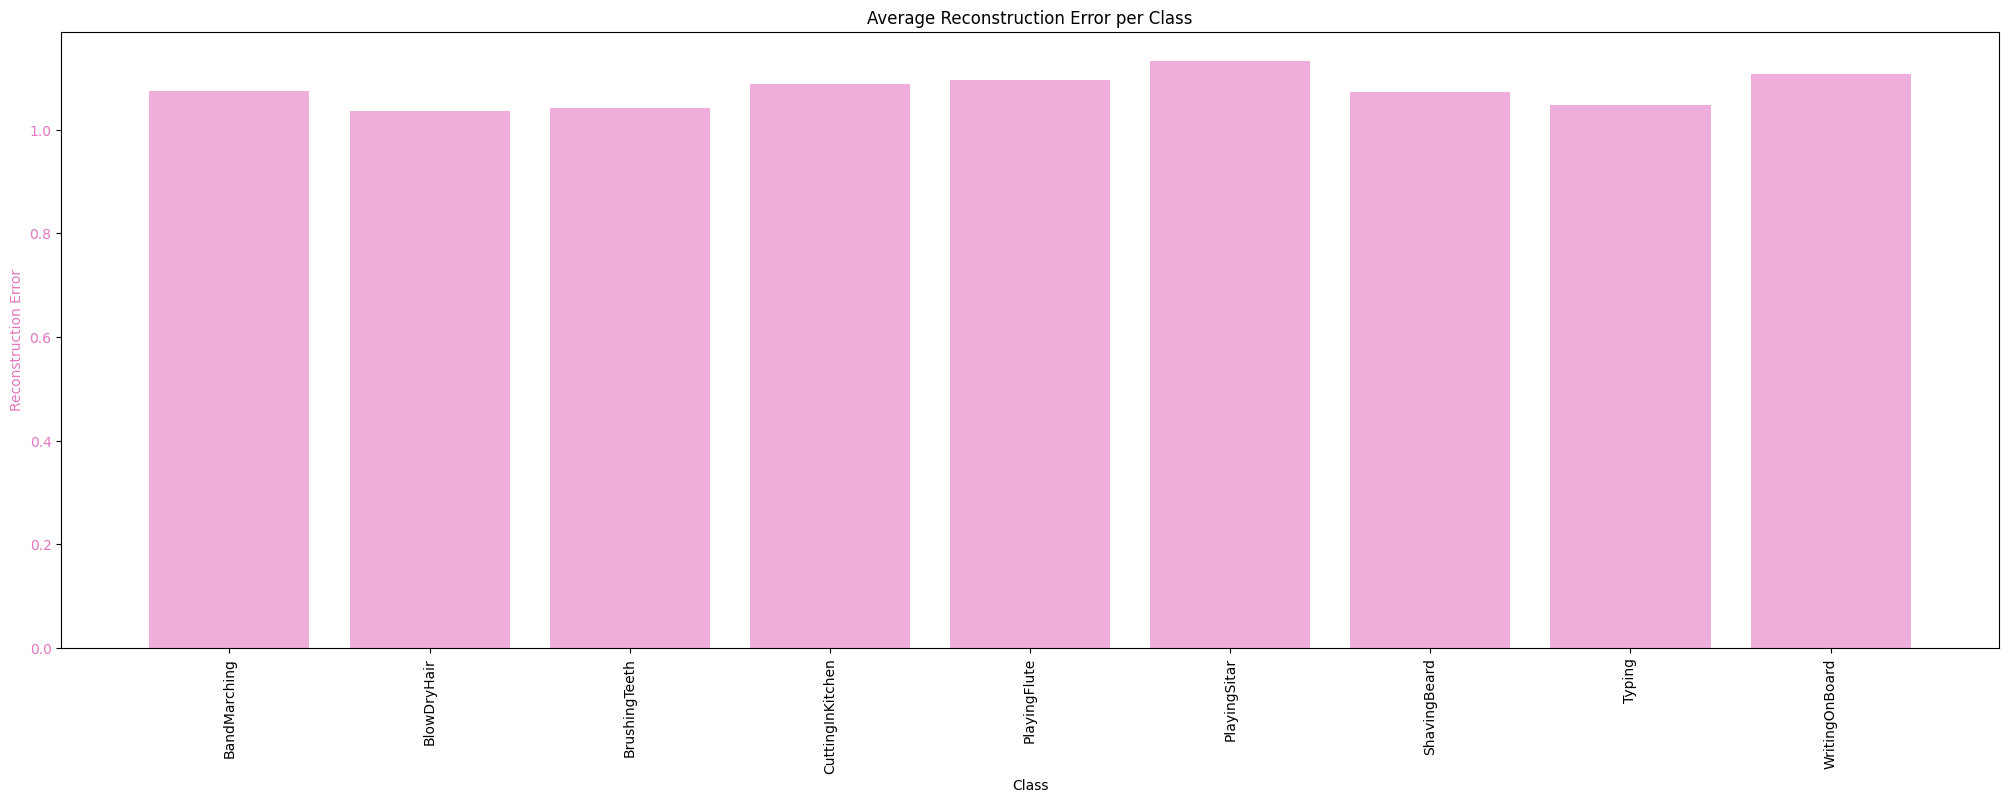

In [ ]:
import collections

def recon_err_per_class(total_losses, total_labels, classes):
    # loss
    loss_per_class = {class_id: [] for class_id in range(len(classes))}
    for i, label in enumerate(total_labels):
        loss_per_class[label].append(total_losses[i])
    for k, v in loss_per_class.items():
        loss_per_class[k] = np.mean(np.asarray(v))
        # print(k, v)

    # Data
    x = [classes[i] for i in loss_per_class.keys()]
    yloss = list(loss_per_class.values())


    # Create figure and first axis
    fig, ax1 = plt.subplots(figsize=(25, 8))

    # exclude class with 0 data
    x = [x[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]
    filt_yloss = [yloss[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]

    # Plot loss
    color = 'tab:pink'
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Reconstruction Error', color=color)
    ax1.bar(x, filt_yloss, color=color, alpha=0.6, label='Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)

    # Create second axis for accuracy

    # Title and legend
    plt.title('Average Reconstruction Error per Class')
    # Show plot
    plt.show()

    return


recon_err_per_class(total_recon_losses, total_labels, class_labels)


In [ ]:
# get reconstruction video
sample_video = next(iter(test_seen_dataset))

num_patches_per_frame = (model.config.image_size // model.config.patch_size) ** 2
seq_length = (model.config.num_frames // model.config.tubelet_size) * num_patches_per_frame
bool_masked_pos = torch.randint(0, 2, (1, seq_length)).bool()

video_for_recon = sample_video["video"].permute(1, 0, 2, 3)

with torch.no_grad():
    print(video_for_recon.unsqueeze(0).shape)
    outputs = recon_model(video_for_recon.unsqueeze(0), bool_masked_pos=bool_masked_pos)
    pixel_recon = outputs.logits



torch.Size([1, 16, 3, 224, 224])


In [ ]:
print(pixel_recon.shape)
# 1536 = 3 (channel)  * 16 * 16 (patch size) * 2 (tubelet_size)

torch.Size([1, 763, 1536])


In [ ]:
print('num_patches_per_frame', num_patches_per_frame)
print('model.config.image_size', model.config.image_size)
print("model.config.patch_size", model.config.patch_size)

print('model.config.tubelet_size', model.config.tubelet_size)
print('model.config.num_frames', model.config.num_frames)
print('seq_length', seq_length)

print('bool_masked_pos', torch.sum(bool_masked_pos), bool_masked_pos.shape)

num_patches_per_frame 196
model.config.image_size 224
model.config.patch_size 16
model.config.tubelet_size 2
model.config.num_frames 16
seq_length 1568
bool_masked_pos tensor(823) torch.Size([1, 1568])


## tsne

In [ ]:
from transformers import VideoMAEModel
feat_model = VideoMAEModel.from_pretrained(model_ckpt)

Some weights of the model checkpoint at feliciaaaluo/videomae-base-finetuned-ucf101 were not used when initializing VideoMAEModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing VideoMAEModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VideoMAEModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from tqdm import tqdm

def feat_inference(model, dataset):

    total_feats = []
    total_labels = []

    num_patches_per_frame = (model.config.image_size // model.config.patch_size) ** 2
    seq_length = (model.config.num_frames // model.config.tubelet_size) * num_patches_per_frame
    bool_masked_pos = torch.randint(0, 2, (1, seq_length)).bool()

    i = 0
    for dict_file in tqdm(dataset):
        video = dict_file["video"].permute(1, 0, 2, 3)
        label = dict_file['label']
        inputs = {
            "pixel_values": video.unsqueeze(0),
            # "labels": torch.tensor(label)
        }
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        model = model.to(device)

        # forward pass
        with torch.no_grad():
            outputs = model(**inputs)
            feat = outputs.last_hidden_state # (1, 1568, 768) 14*14*8 = 1568

        total_feats.append(feat)
        total_labels.append(label)

        i += 1
        if i == 4000: break

    total_feats = torch.cat(total_feats, dim=0).cpu().detach().numpy()
    total_labels = np.asarray(total_labels)

    return total_feats, total_labels

total_feats, total_labels = feat_inference(feat_model, test_unseen_dataset)

3999it [07:24,  9.00it/s]


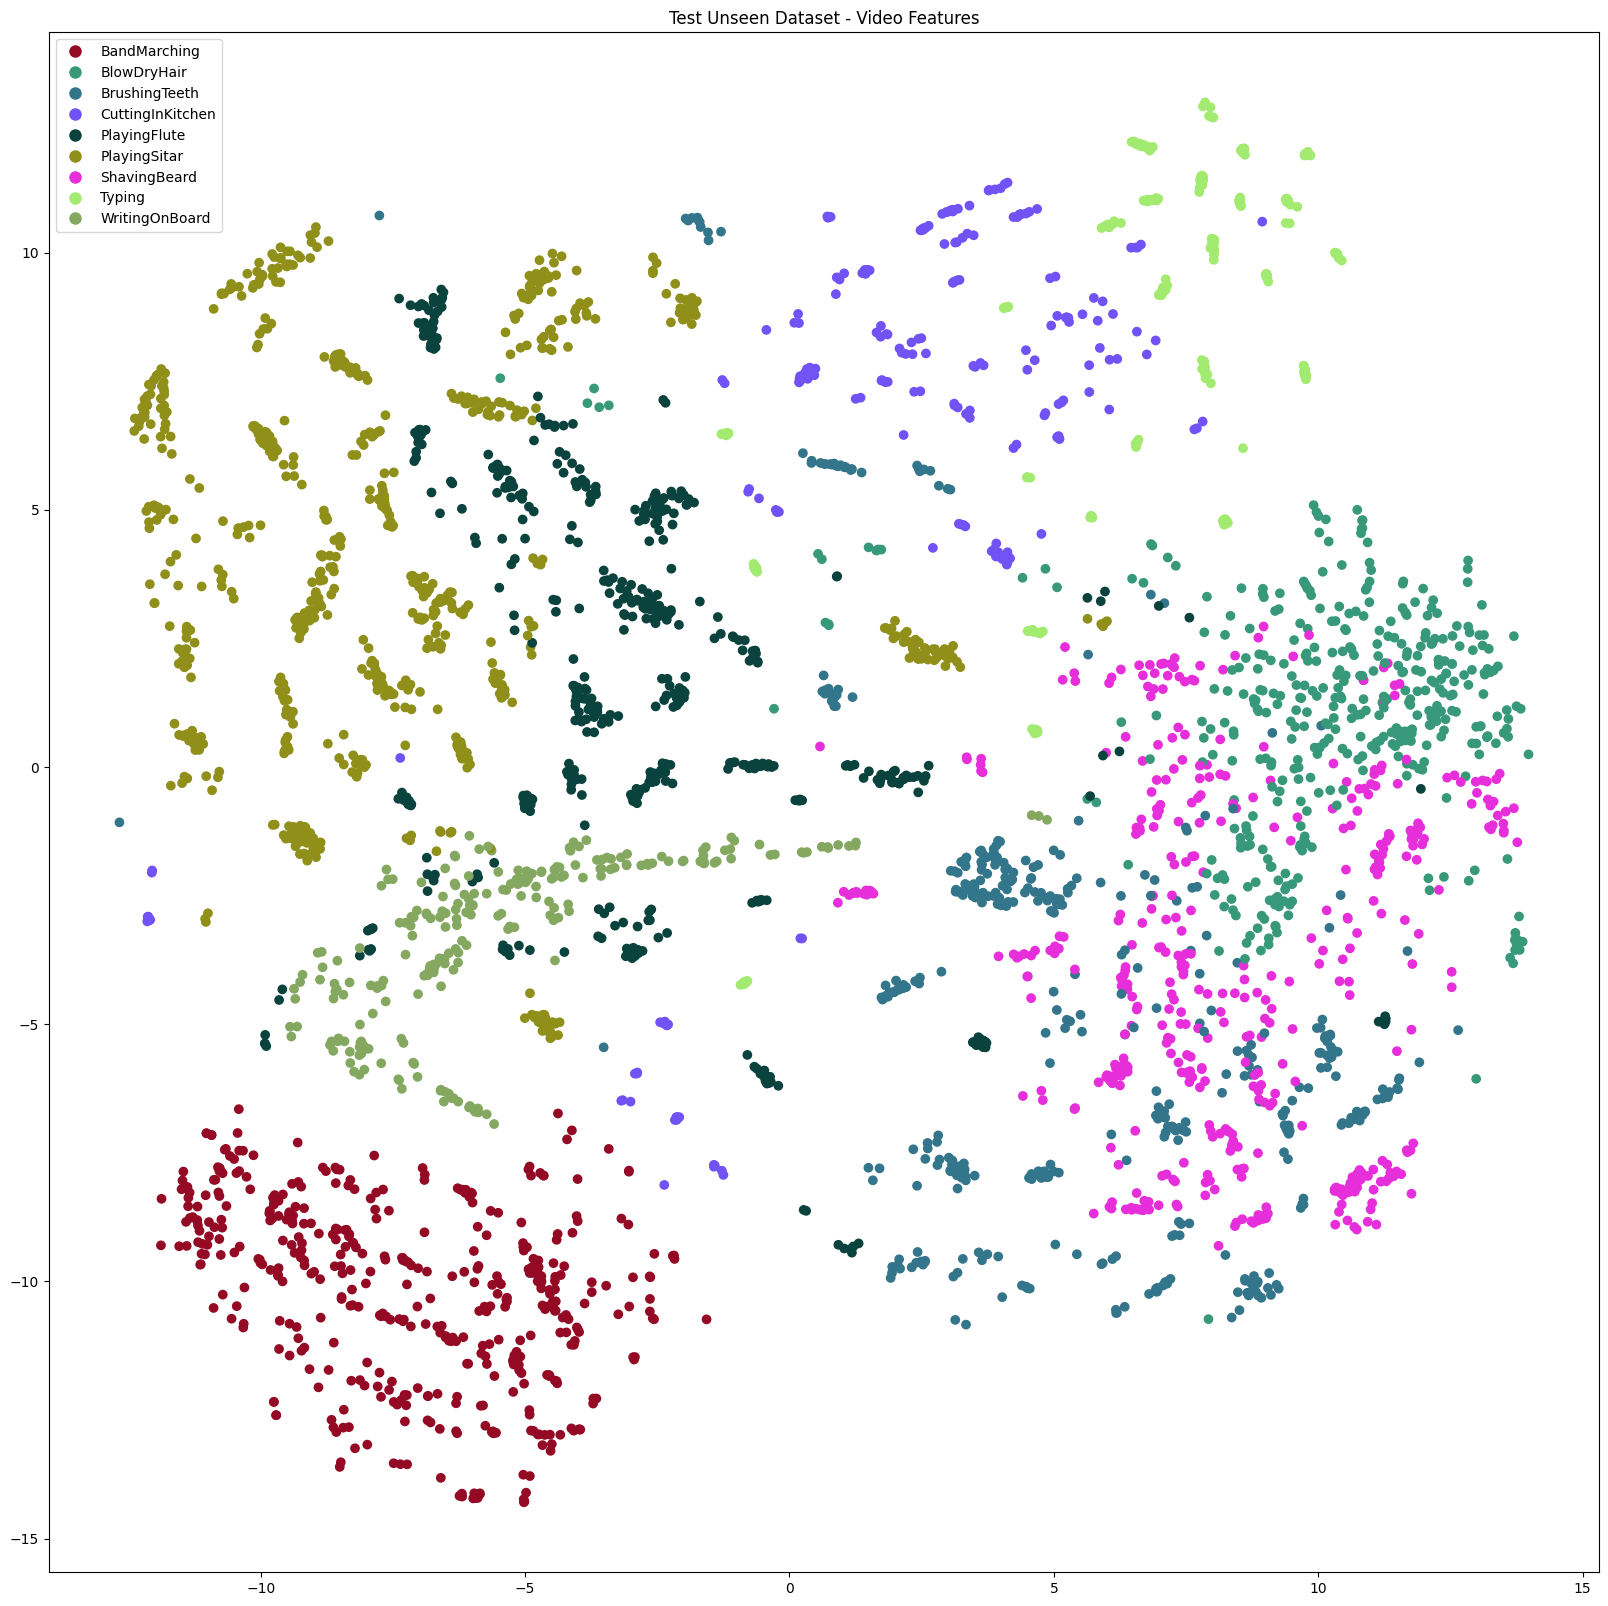

In [ ]:
from matplotlib import cm
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt



def tsne(total_labels, total_features, classes, title):

    # tsne color
    r, g, b = np.linspace(0, 1, 51), np.linspace(0, 1, 51), np.linspace(0, 1, 51)
    np.random.seed(0)
    np.random.shuffle(r)
    np.random.shuffle(g)
    np.random.shuffle(b)
    r = r.reshape((-1, 1))
    g = g.reshape((-1, 1))
    b = b.reshape((-1, 1))
    class_colors = np.concatenate((r, g, b), axis=1)
    colors = class_colors[total_labels]

    # compute 2d tsne
    b, s, d = total_features.shape
    total_features = total_features.reshape(b, s * d)
    tsne = TSNE(n_components=2, perplexity=800) # perplexity=8
    X_2d = tsne.fit_transform(total_features)

    # plot
    plt.figure(figsize=(20, 20))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors)

    # legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=classes[i], markersize=10,
                          markerfacecolor=class_colors[i]) for i in range(len(classes))]
    plt.title(title)
    plt.legend(handles=legend_elements, loc='upper left')

    plt.show()

    return

tsne(total_labels, total_feats, class_labels, title='Test Unseen Dataset - Video Features')
